In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2, os
import keras


In [4]:
vgg_notop=tf.keras.applications.VGG16(include_top=False, input_shape=(220,220,3))

58889256/58889256 [==============================] - 2s 0us/step


In [5]:
vgg_notop.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 220, 220, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 220, 220, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 110, 110, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 110, 110, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 110, 110, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 55, 55, 128)       0     

In [6]:
! mkdir -p /root/.kaggle


In [7]:
! mv kaggle.json /root/.kaggle
import kaggle

In [8]:
! kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:21<00:00, 40.6MB/s]
100% 812M/812M [00:22<00:00, 38.6MB/s]


In [9]:
! unzip -q dogs-vs-cats.zip

In [10]:
! unzip -q train.zip

In [11]:
# Flow from dataframe
df=pd.DataFrame(columns=["filename", "label"])
df["filename"]=os.listdir("train/")

In [12]:
df

,filename,label
0,cat.5497.jpg,NaN
1,cat.7567.jpg,NaN
2,dog.4590.jpg,NaN
3,cat.4823.jpg,NaN
4,dog.10859.jpg,NaN
...,...,...
24995,cat.5029.jpg,NaN
24996,cat.3883.jpg,NaN
24997,cat.10262.jpg,NaN
24998,dog.2552.jpg,NaN


In [13]:
df["label"]=df["filename"].str.split(".", expand=True)[0]

In [14]:
df

,filename,label
0,cat.5497.jpg,cat
1,cat.7567.jpg,cat
2,dog.4590.jpg,dog
3,cat.4823.jpg,cat
4,dog.10859.jpg,dog
...,...,...
24995,cat.5029.jpg,cat
24996,cat.3883.jpg,cat
24997,cat.10262.jpg,cat
24998,dog.2552.jpg,dog


In [15]:
df["test_image"]=None


In [16]:
df.loc[np.random.randint(0,25000-1, 1000), "test_image"]=True

In [17]:
df.loc[df.test_image==True].shape

(982, 3)

In [18]:
df.loc[df.test_image!=True].shape

(24018, 3)

In [19]:
idg=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.1
)

In [20]:
train_idg=idg.flow_from_dataframe(df.loc[df.test_image!=True], directory="train/", x_col="filename",
                                  y_col="label", target_size=(220,220), batch_size=64,
                                  subset="training")

Found 21617 validated image filenames belonging to 2 classes.


In [21]:
val_idg=idg.flow_from_dataframe(df.loc[df.test_image!=True], directory="train/",
                                x_col="filename", y_col="label",
                                target_size=(220,220), batch_size=64,
                                subset="validation")

Found 2401 validated image filenames belonging to 2 classes.


In [22]:
for layer in vgg_notop.layers:
  layer.trainable=False

In [23]:
for layer in vgg_notop.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [24]:
flat=tf.keras.layers.Flatten() (vgg_notop.output)
dense_1=tf.keras.layers.Dense(256, activation="relu") (flat)
dense_2=tf.keras.layers.Dense(256, activation="relu") (dense_1)
output=tf.keras.layers.Dense(2, activation="softmax") (dense_2)

In [25]:
model=tf.keras.models.Model(inputs=[vgg_notop.input], outputs=[output])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 220, 220, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 220, 220, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 110, 110, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 110, 110, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 110, 110, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 55, 55, 128)       0     

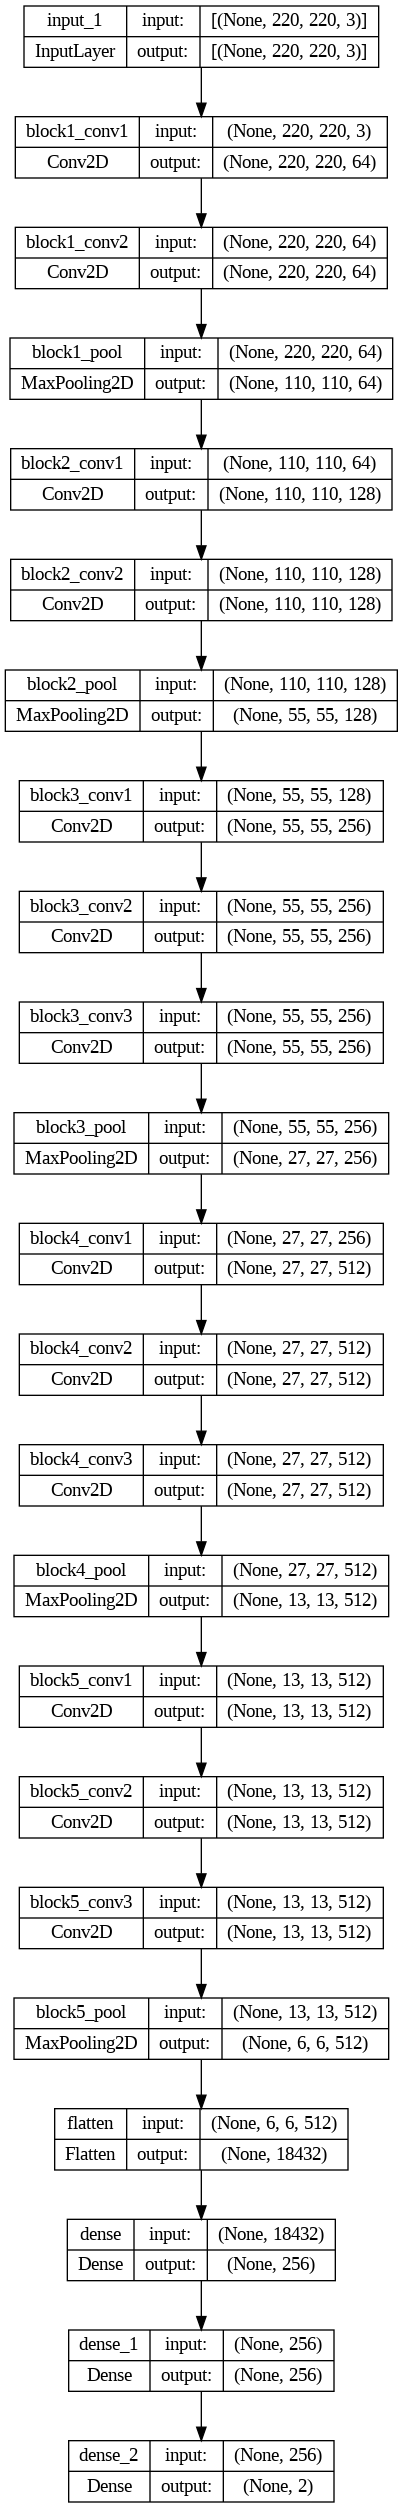

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [28]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["accuracy"])

In [29]:
model.fit(train_idg, batch_size=64, validation_data=val_idg, epochs=10)

Epoch 1/10
338/338 [==============================] - 129s 339ms/step - loss: nan - accuracy: 0.5018 - val_loss: nan - val_accuracy: 0.4994
Epoch 2/10
338/338 [==============================] - 100s 296ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4994
Epoch 3/10
338/338 [==============================] - 100s 295ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4994
Epoch 4/10
338/338 [==============================] - 100s 295ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4994
Epoch 5/10
338/338 [==============================] - 100s 294ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4994
Epoch 6/10
338/338 [==============================] - 100s 295ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4994
Epoch 7/10
338/338 [==============================] - 100s 295ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4994
Epoch 8/10
338/338 [

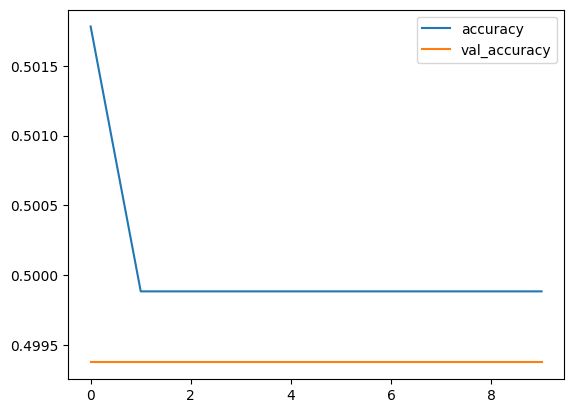

In [32]:
import matplotlib.pyplot as plt
plt.plot(model.history.history["accuracy"], label="accuracy")
plt.plot(model.history.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [33]:
model.save

<bound method Model.save of <keras.src.engine.functional.Functional object at 0x7cdd24b1f2e0>>